In [66]:
dimport argparse

def args_parser():
    parser = argparse.ArgumentParser()
    # federated arguments
    parser.add_argument('--epochs', type=int, default=500, help="rounds of training")
    parser.add_argument('--num_users', type=int, default=100, help="number of users: K")
    parser.add_argument('--frac', type=float, default=0.1, help="the fraction of clients: C")
    parser.add_argument('--local_ep', type=int, default=5, help="the number of local epochs: E")
    parser.add_argument('--local_bs', type=int, default=10, help="local batch size: B")
    parser.add_argument('--bs', type=int, default=128, help="test batch size")
    parser.add_argument('--lr', type=float, default=0.001, help="learning rate (default: 0.01)")
    parser.add_argument('--lr_decay', type=float, default=0.95, help="lr decay")
    parser.add_argument('--momentum', type=float, default=0.5, help="SGD momentum (default: 0.5)")
    parser.add_argument('--split', type=str, default='user', help="train-test split type, user or sample")

    # model arguments
    parser.add_argument('--model', type=str, default='cnn', help='model name')
    parser.add_argument('--kernel_num', type=int, default=9, help='number of each kind of kernel')
    parser.add_argument('--kernel_sizes', type=str, default='3,4,5',
                        help='comma-separated kernel size to use for convolution')
    parser.add_argument('--norm', type=str, default='batch_norm', help="batch_norm, layer_norm, or None")
    parser.add_argument('--num_filters', type=int, default=32, help="number of filters for conv nets")
    parser.add_argument('--max_pool', type=str, default='True',
                        help="Whether use max pooling rather than strided convolutions")

    # other arguments
    parser.add_argument('--dataset', type=str, default='mnist', help="name of dataset")
    parser.add_argument('--iid', action='store_true', help='whether i.i.d or not')
    parser.add_argument('--num_classes', type=int, default=10, help="number of classes")
    parser.add_argument('--num_channels', type=int, default=1, help="number of channels of imges")
    parser.add_argument('--gpu', type=int, default=-1, help="GPU ID, -1 for CPU")
    parser.add_argument('--stopping_rounds', type=int, default=10, help='rounds of early stopping')
    parser.add_argument('--verbose', action='store_true', help='verbose print')
    parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
    parser.add_argument('--all_clients', action='store_true', help='aggregation over all clients')
    args = parser.parse_args(args=[])
    return args

In [67]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
import random
from torchvision import datasets, transforms
from collections import deque
  
import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar
from models.Fed import FedAvg
from models.test import test_img

# parse args
args = args_parser()
args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.repeat(1,1,1))])
    dataset_train = datasets.MNIST('./data/mnist/', train=True, download=False, transform=trans_mnist)
    dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    args.iid = False
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

CNNMnist(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [68]:
class MemoryBuffer: # MemoryBuffer类实现的功能：buffer内采样，往buffer里塞（sars）

    def __init__(self, size):
        self.buffer = deque(maxlen=size) #buffer设置为双端队列
        self.maxSize = size
        self.len = 0
        
    def state_reco(self, s):
        s_1 = [i[0] for i in s]
        s_2 = [i[1] for i in s]
        s_3 = [i[2] for i in s]
        return [torch.cat(s_1),torch.cat(s_2),torch.cat(s_3)]

    def sample(self, count):
        """
        samples a random batch from the replay memory buffer
        :param count: batch size
        :return: batch (numpy array)
        """
        batch = []
        count = min(count, self.len)
        batch = random.sample(self.buffer, count) # 随机取样

        s_arr = [arr[0] for arr in batch]
        a_arr = torch.cat([arr[1] for arr in batch])
        r_arr = torch.tensor([arr[2] for arr in batch]).reshape(-1,1)
        s1_arr = [arr[3] for arr in batch]

        return self.state_reco(s_arr), a_arr, r_arr, self.state_reco(s1_arr)

    def len(self):
        return self.len

    def add(self, s, a, r, s1):
        """
        adds a particular transaction in the memory buffer
        :param s: current state
        :param a: action taken
        :param r: reward received
        :param s1: next state
        :return:
        """
        transition = (s,a,r,s1)
        self.len += 1
        if self.len > self.maxSize:
            self.len = self.maxSize
        self.buffer.append(transition)

In [69]:
class Actor(nn.Module):

    def __init__(self, parameter_dim, loss_dim, action_dim):
        super(Actor, self).__init__()

        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim

        self.fc1 = nn.Linear(parameter_dim,action_dim)

        self.fc2 = nn.Linear(action_dim*12,action_dim)

    def forward(self, parameters, last_loss, last_weight):
        parameter_lst = []
        for i in range(self.action_dim):
            parameter_lst.append(self.fc1(parameters[:,i,:]))
        parameter_layer = torch.cat(parameter_lst,dim=1)
        x = torch.cat([parameter_layer,last_loss, last_weight],dim=1)
        action = F.softmax(self.fc2(x),dim=1)

        return action

class Critic(nn.Module):

    def __init__(self, parameter_dim, loss_dim, action_dim):
        super(Critic, self).__init__()

        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim

        self.fc1 = nn.Linear(parameter_dim,action_dim)

        self.fc2 = nn.Linear(action_dim*13,1)

    def forward(self, parameters, last_loss, last_weight, action):
        parameter_lst = []
        for i in range(self.action_dim):
            parameter_lst.append(self.fc1(parameters[:,i,:]))
        parameter_layer = torch.cat(parameter_lst,dim=1)
        x = torch.cat([parameter_layer,last_loss, last_weight, action],dim=1)
        q = self.fc2(x)

        return q

In [70]:
GAMMA=0.8
class Trainer:

    def __init__(self, parameter_dim, loss_dim, action_dim, replay_buffer):
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.iter = 0
        #self.noise = utils.OrnsteinUhlenbeckActionNoise(self.action_dim)

        self.actor = Actor(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim)
        self.target_actor = Actor(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),0.01)

        self.critic = Critic(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim)
        self.target_critic = Critic(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),0.01)

        self.hard_update(self.target_actor, self.actor)
        self.hard_update(self.target_critic, self.critic)

    def soft_update(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - tau) + param.data * tau
            )
    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(param.data)
                
    def get_exploitation_action(self, parameters, last_loss, last_weight):
        action = self.target_actor.forward(parameters, last_loss, last_weight).detach()
        return action.data.numpy()

#     def get_exploration_action(self, state):
#         """
#         gets the action from actor added with exploration noise
#         :param state: state (Numpy array)
#         :return: sampled action (Numpy array)
#         """
#         state = Variable(torch.from_numpy(state))
#         action = self.actor.forward(state).detach()
#         new_action = action.data.numpy() + (self.noise.sample())
#         return new_action

    def optimize(self):
        """
        Samples a random batch from replay memory and performs optimization
        :return:
        """
        s1,a1,r1,s2 = self.replay_buffer.sample(8)

#         s1 = Variable(torch.from_numpy(s1))
#         a1 = Variable(torch.from_numpy(a1))
#         r1 = Variable(torch.from_numpy(r1))
#         s2 = Variable(torch.from_numpy(s2))

        # ---------------------- optimize critic ----------------------
        # Use target actor exploitation policy here for loss evaluation
        # 这里应该是TD的方法
        a2 = self.target_actor.forward(s2[0],s2[1],s2[2]).detach()
        next_val = torch.squeeze(self.target_critic.forward(s2[0],s2[1],s2[2], a2).detach())
        # y_exp = r + gamma*Q'( s2, pi'(s2))
        y_expected = r1 + GAMMA*next_val
        # y_pred = Q( s1, a1)
        y_predicted = torch.squeeze(self.critic.forward(s1[0],s1[1],s1[2], a1))
        # compute critic loss, and update the critic
        loss_critic = F.smooth_l1_loss(y_predicted, y_expected)
        self.critic_optimizer.zero_grad()
        loss_critic.backward(retain_graph=True)
        self.critic_optimizer.step()

        # ---------------------- optimize actor ----------------------
        pred_a1 = self.actor.forward(s1[0],s1[1],s1[2])
        loss_actor = -1*torch.sum(self.critic.forward(s1[0],s1[1],s1[2], pred_a1))
        self.actor_optimizer.zero_grad()
        loss_actor.backward(retain_graph=True)
        self.actor_optimizer.step()

        self.soft_update(self.target_actor, self.actor, 0.001)
        self.soft_update(self.target_critic, self.critic, 0.001)

        # if self.iter % 100 == 0:
        #     print 'Iteration :- ', self.iter, ' Loss_actor :- ', loss_actor.data.numpy(),\
        #         ' Loss_critic :- ', loss_critic.data.numpy()
        # self.iter += 1

    def save_models(self, episode_count):
        torch.save(self.target_actor.state_dict(), './Models/' + str(episode_count) + '_actor.pt')
        torch.save(self.target_critic.state_dict(), './Models/' + str(episode_count) + '_critic.pt')
        
    def load_models(self, episode):
        self.actor.load_state_dict(torch.load('./Models/' + str(episode) + '_actor.pt'))
        self.critic.load_state_dict(torch.load('./Models/' + str(episode) + '_critic.pt'))
        utils.hard_update(self.target_actor, self.actor)
        utils.hard_update(self.target_critic, self.critic)

In [71]:
paramter = []
for i in w_glob.keys():
    paramter.append(w_glob[i].reshape(1,-1))

parameter_dim = torch.cat(paramter,axis=1).shape[1]
loss_dim = max(int(args.frac * args.num_users), 1)
action_dim = max(int(args.frac * args.num_users), 1)

In [72]:
replay_buffer = MemoryBuffer(500)
trainer = Trainer(parameter_dim, loss_dim, action_dim, replay_buffer)

In [73]:
def FedPareto(w,action):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(0, len(w)):
            if i==0:
                w_avg[k] = action[i] * w[i][k]
            else:
                w_avg[k] += action[i] * w[i][k]
    return w_avg

In [74]:
# training
loss_train = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

loss_save = []

last_replay_data = []
for iter in range(args.epochs):
    if iter==0:
        random_n = 0
        n_weight = []
        while random_n<10:
            n_weight.append(random.random()) # 随机初始化参数
            random_n+=1
        action = F.softmax(torch.tensor(n_weight))
    loss_locals = []
    w_locals = []
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    p_collect = []
    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        ############ 储存参数 ##############
        p_local = []
        for i in w.keys():
            p_local.append(w[i].reshape(1,-1))
        p_collect.append(torch.cat(p_local,axis=1))
        ############ 储存loss ##############
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    p_collect = torch.cat(p_collect).unsqueeze(0)
    action_next = trainer.target_actor.forward(p_collect,
                                          torch.tensor(loss_locals).reshape(1,-1), 
                                          action.reshape(1,-1))[0]
    ###########计算当前轮的reward，然后将当前轮的reward添加到上一个replay_data中
    reward = -sum(loss_locals) / len(loss_locals)
    loss_save.append(reward)
    if len(last_replay_data)==2:
        last_replay_data.append(reward)#r
        last_replay_data.append([p_collect, 
                                 torch.tensor(loss_locals).reshape(1,-1), 
                                 action.reshape(1,-1)])#s_next
        trainer.replay_buffer.add(last_replay_data[0],
                                  last_replay_data[1],
                                  last_replay_data[2],
                                  last_replay_data[3])
    last_replay_data = [[p_collect, 
                         torch.tensor(loss_locals).reshape(1,-1), 
                         action.reshape(1,-1)], 
                        action_next.reshape(1,-1)]#s, a
    action = action_next
    # update global weights
    # w_glob = FedAvg(w_locals)
    w_glob = FedPareto(w_locals, action_next)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    print('Round {:3d}, Average loss {:.3f}'.format(iter, -reward))
    loss_train.append(-reward)
    
    if iter > 0:
        trainer.optimize()
    args.lr = max(args.lr*args.lr_decay, 0.001)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Round   0, Average loss 1.743
Round   1, Average loss 1.001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Round   2, Average loss 0.918


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([2, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Round   3, Average loss 0.521


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([3, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Round   4, Average loss 0.619


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([4, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Round   5, Average loss 0.562


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([5, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Round   6, Average loss 0.489


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([6, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Round   7, Average loss 0.420


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([7, 7])) that is different to the input size (torch.Size([7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Round   8, Average loss 0.362


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([8, 8])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Round   9, Average loss 0.269
Round  10, Average loss 0.359
Round  11, Average loss 0.336
Round  12, Average loss 0.310
Round  13, Average loss 0.329
Round  14, Average loss 0.264
Round  15, Average loss 0.341
Round  16, Average loss 0.294
Round  17, Average loss 0.302
Round  18, Average loss 0.338
Round  19, Average loss 0.266
Round  20, Average loss 0.176
Round  21, Average loss 0.163
Round  22, Average loss 0.230
Round  23, Average loss 0.278
Round  24, Average loss 0.172
Round  25, Average loss 0.284
Round  26, Average loss 0.212
Round  27, Average loss 0.238
Round  28, Average loss 0.248
Round  29, Average loss 0.260
Round  30, Average loss 0.179
Round  31, Average loss 0.188
Round  32, Average loss 0.204
Round  33, Average loss 0.139
Round  34, Average loss 0.217
Round  35, Average loss 0.198
Round  36, Average loss 0.206
Round  37, Average loss 0.174
Round  38, Average loss 0.189
Round  39, Average loss 0.149
Round  40, Average loss 0.146
Round  41, Average loss 0.167
Round  42,

KeyboardInterrupt: 

In [79]:
# plot loss curve
# plt.figure()
# plt.plot(range(len(loss_train)), loss_train)
# plt.ylabel('train_loss')
# plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

# testing
net_glob.eval()
acc_train, loss_train = test_img(net_glob, dataset_train, args)
acc_test, loss_test = test_img(net_glob, dataset_test, args)
print("Training accuracy: {:.2f}".format(acc_train))
print("Testing accuracy: {:.2f}".format(acc_test))

Training accuracy: 56.29
Testing accuracy: 56.48


In [ ]:
loss_train

In [ ]:
loss_save

<function matplotlib.pyplot.show(*args, **kw)>

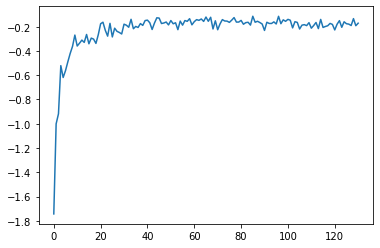

In [77]:
%matplotlib inline

plt.plot(range(len(loss_save)), loss_save)
plt.show